In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
#!git clone https://github.com/europeana/rd-img-classification-pilot.git

import sys
sys.path.append('../src')

import os
import json
import requests
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


from torch_utils import ResNet
from harvest_data import parse_CHO
from download_images import url2img
from gradcam import grad_cam


In [81]:
class EuropeanaAPI:
    
  def __init__(self,wskey):
    self.wskey = wskey

  def search(self,query,reusability='open',n=20):
    
    CHO_list = []
    
    params = {
        'reusability':reusability,
        'media':True,
        'qf':'TYPE:IMAGE', 
        'query':query, 
        'wskey':'api2demo'
    }
    
    response = {'nextCursor':'*'}
    while 'nextCursor' in response:
      params.update({'cursor':response['nextCursor']})
      response = requests.get('https://www.europeana.eu/api/v2/search.json', params = params).json()
      
      CHO_list += response['items']

      if len(CHO_list)>n:
        break

    return CHO_list[:n]

In [82]:
def load_model(root_path, device):
    checkpoint_path = os.path.join(root_path,'checkpoint.pth')

    model = ResNet(34,20)
    if not torch.cuda.is_available():
        model.load_state_dict(torch.load(checkpoint_path,map_location=torch.device('cpu')))
    else:
        model.load_state_dict(torch.load(checkpoint_path))

    model = model.to(device)
    model.eval()

    with open(os.path.join(root_path,'class_index.json'),'r') as f:
        class_index_dict = json.load(f)
        
    return model, class_index_dict
    
    

In [74]:
def predict(model,img,device):
    transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    heatmap_layer = model.net.layer4[1].conv2
    image_interpretable,idx_pred,conf = grad_cam(model, img, heatmap_layer, transform, device)
    return idx_pred,conf,image_interpretable

def plot_prediction(img,XAI_img):

    fig,ax = plt.subplots(1,2,figsize=(20,20))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[1].imshow(XAI_img)
    ax[1].axis('off')
    plt.show()
    return 

In [75]:
root_path = '../model_zoo/3000'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model,class_index_dict = load_model(root_path, device)


In [76]:
class_index_dict

{'0': 'archaeological_site',
 '1': 'building',
 '2': 'ceramics',
 '3': 'clothing',
 '4': 'costume_accessories',
 '5': 'drawing',
 '6': 'furniture',
 '7': 'inscription',
 '8': 'jewellery',
 '9': 'map',
 '10': 'painting',
 '11': 'photograph',
 '12': 'postcard',
 '13': 'sculpture',
 '14': 'specimen',
 '15': 'tapestry',
 '16': 'textile',
 '17': 'toy',
 '18': 'weaponry',
 '19': 'woodwork'}

In [89]:
eu = EuropeanaAPI('api2demo')
CHO_list = eu.search('Europe',reusability = 'open',n = 5)

URI:  http://data.europeana.eu/item/256/contributions_20afcec0_d4e1_0138_2766_6eee0af4452b
prediction: photograph, confidence: 0.995


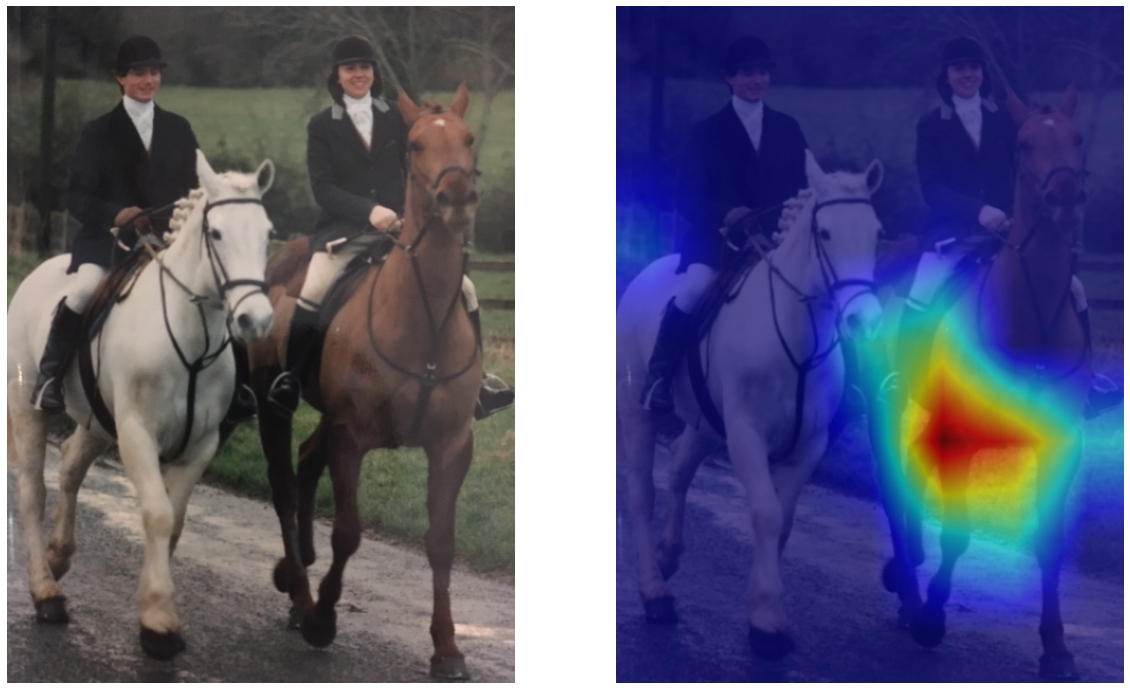






URI:  http://data.europeana.eu/item/256/contributions_2b2b74c0_8889_0138_d9df_6eee0af41c2c
prediction: map, confidence: 0.405


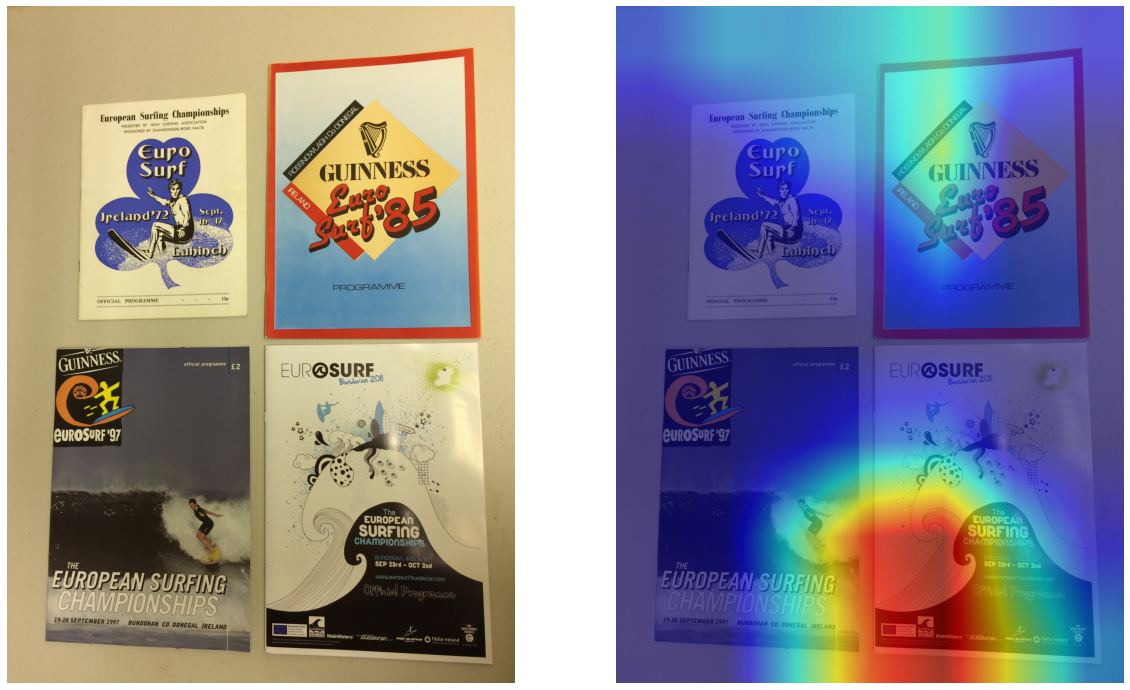






URI:  http://data.europeana.eu/item/256/contributions_39aa05a0_f4f4_0138_402c_6eee0af58c4a
prediction: photograph, confidence: 0.666


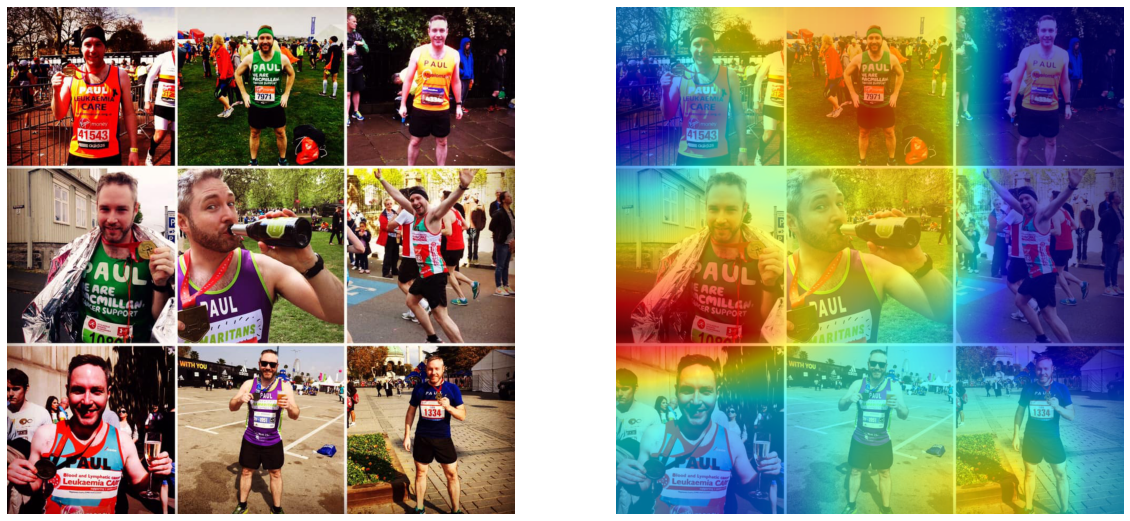






URI:  http://data.europeana.eu/item/256/contributions_50eeeab0_e945_0138_d0e9_6eee0af60c2c
prediction: photograph, confidence: 1.000


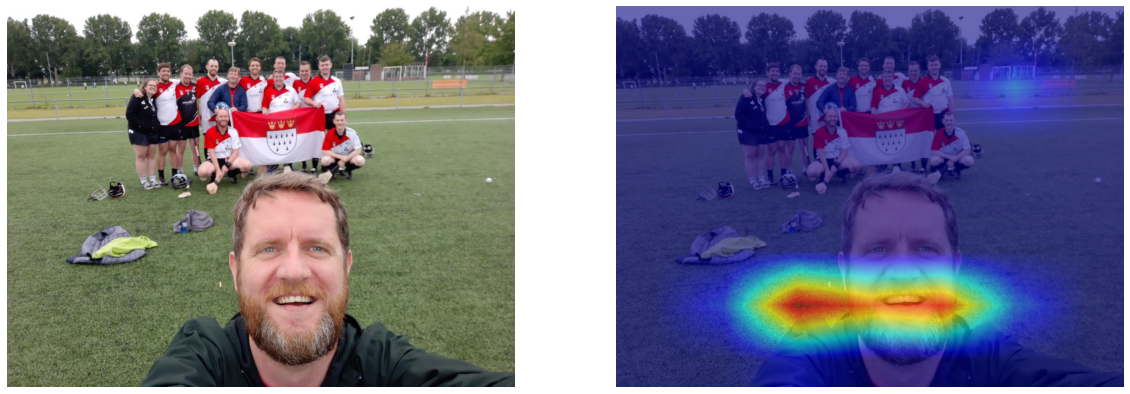






URI:  http://data.europeana.eu/item/256/contributions_66c08cc0_1481_0139_0e8a_6eee0af51421
prediction: postcard, confidence: 0.945


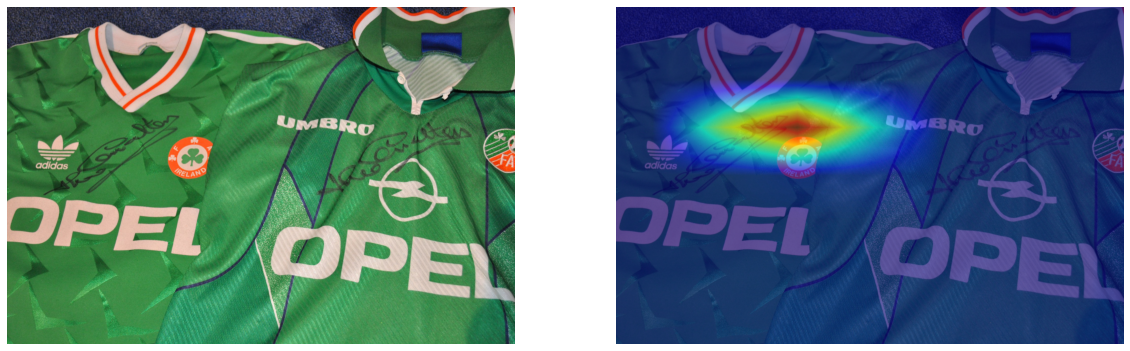

In [90]:
for CHO in CHO_list:
    ID,URI,URL = parse_CHO(CHO)
    img = url2img(URL)
    if not img:
        continue
        
    idx_pred, conf, XAI_img = predict(model,img,device)
    pred =  class_index_dict[str(idx_pred)]

    print('URI: ','http://data.europeana.eu/item'+CHO['id'])
    print(f'prediction: {pred}, confidence: {conf:.3f}')

    plot_prediction(img,XAI_img)
    print(4*'\n')

